In [6]:
import sys, os, pickle
import torch
sys.path.append('/home/om2382/mft-theory/')
from cluster import *
from core import *
from empirics import *
from functions import *
from ode_methods import *
from plotting import *
from theory import *
from utils import *
from functools import partial
import matplotlib.pyplot as plt

In [2]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 10
macro_configs = config_generator(PR_D=[2**beta for beta in [-0.5, -1, -1.5, -2, -2.5, -3, -3.5, -4]],
                                 g=[3, 6, 10])

micro_configs = tuple(product(macro_configs, list(range(n_seeds))))
prototype = False

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
    prototype = True
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [3]:
### --- Set empirical parameters --- ###

#network properties size
N = 6500
#g = params['g']
g = 6
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)

In [4]:
### --- Estimate psi empirically --- ###

#Generate LDRG matrix

#PR_D = params['PR_D']
PR_D = 2**(-4)
PR_G = 1

if PR_D < 1:
    alpha = 1
else:
    alpha = PR_D
    
K = int(alpha * N)
L = np.random.normal(0, 1/np.sqrt(N), (N, K))
RT = np.random.normal(0, 1/np.sqrt(N), (K, N))

#if PR_D < 1:
#    beta_D = invert_PR_by_newton(PR_D)
#    D = np.exp(-beta_D*np.arange(K)/K)
#else:
#    D = np.ones(K)

### --- Step function D --- ###
D = np.ones(N)
D[int(PR_D*N):] = 0
    
if PR_G < 1:
    beta_G = invert_PR_by_newton(PR_G)
    G = np.exp(-beta_G*np.arange(N)/N)
else:
    G = np.ones(N)

g_correction = g / np.sqrt(np.sum(D**2)/N*np.sum(G**2)/N)
D = D * g_correction

L = torch.from_numpy(L).type(torch.FloatTensor).to(0)
D_ = torch.from_numpy(D).type(torch.FloatTensor).to(0)
RT = torch.from_numpy(RT).type(torch.FloatTensor).to(0)
G_ = torch.from_numpy(G).type(torch.FloatTensor).to(0)

W = torch.einsum('ik, k, kj, j -> ij', L, D_, RT, G_)
del L
del RT

In [5]:
U, S, V = torch.linalg.svd(W)

(0.01, 1000.0)

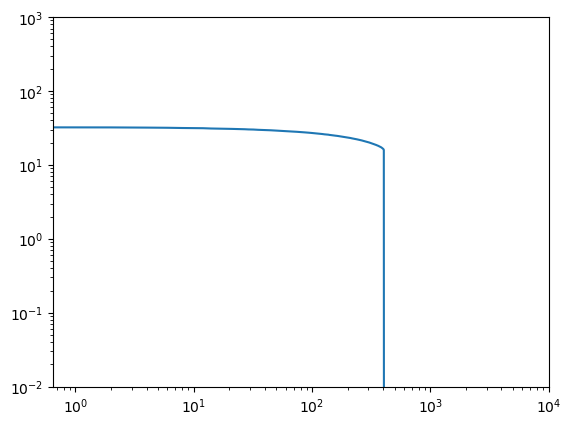

In [10]:
plt.plot(S.cpu().detach().numpy())
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-2, 1e3])

In [ ]:
### --- Estimate spectrum empirically --- ###

W_ = W
x_cov, r_cov = estimate_cov_eigs(T_sim=2000, dt_save=1, dt=0.05, W=W_, phi_torch=phi_torch,
                                 T_save_delay=1000, N_batch=1, N_loops=100,
                                 return_raw_covs=True, runga_kutta=True)

eigs, vecs = np.linalg.eigh(r_cov)
eigs_x, vecs = np.linalg.eigh(x_cov)
ordered_eigs = sorted(np.abs(eigs))[::-1]
ordered_eigs_x = sorted(np.abs(eigs_x))[::-1]

In [ ]:
processed_data = np.array([ordered_eigs, ordered_eigs_x, D])

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': None, 'i_seed': i_seed, 'config': params,
          'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [ ]:
###Truncate file above
file_name = 'LDRG_spectra_PRD_g_shapes'
job_name = 'LDRG_spectra_step_D_final_2'
project_dir = '/home/om2382/low-rank-dims/'
main_script_path = os.path.join(project_dir, 'cluster_main_scripts', job_name + '.py')
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py {}'.format(file_name, main_script_path))

In [ ]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name),
               mem=64, n_hours=24, n_gpus=1,
               results_subdir='PRL_Submission')
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
submit_job(job_script_path, n_jobs, execute=False, results_subdir='PRL_Submission',
           lkumar=False)

In [ ]:
###Get job status
get_ipython().system('squeue -u om2382')

In [ ]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'LDRG_spectra_step_D_final_2'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
sim_results = unpack_processed_data(job_script_path, results_subdir='PRL_Submission')

In [ ]:
with open('packaged_results/LDRG_spectra_small_PRD_final_2', 'wb') as f:
    pickle.dump(sim_results, f)

In [ ]:
result = {'sim': sim_results}

for g in sim_results[0]['g']:
    T_window = 200
    dT = 0.025
    phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
    phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
    lags = np.arange(0, T_window, dT)
    n_lags = int(T_window/dT)
    lags_full = np.concatenate([-lags[-n_lags:][::-1], lags[1:n_lags], np.array([lags[-1]])])

    ### --- Compute single-unit properties

    d = compute_Delta_0(g=g)
    time, Delta_T = integrate_potential(d, g=g, tau_max=T_window, N_tau=int(T_window/dT))
    Delta_T = fix(Delta_T)
    C_phi_half = compute_C_simple(d, Delta_T)
    avg_gain = compute_phi_prime_avg(d)

    ### --- Compute Psi from theory --- ###

    #Define relevant single-unit functions
    C_phi = np.concatenate([C_phi_half,
                            np.array([C_phi_half[-1]]),
                            C_phi_half[1:][::-1]])
    C_phi_omega = fft(C_phi, dT)
    T = len(C_phi)
    t_indices= np.concatenate([np.arange(0, T//2), np.arange(-T//2, 0)])
    sampfreq = 1/dT
    w = 2*np.pi*sampfreq*t_indices/T
    C_phi_C_phi = np.multiply.outer(C_phi_omega, C_phi_omega)
    S_phi = avg_gain/(np.sqrt(2*np.pi)*(1 + 1j*w))
    S_phi_S_phi = np.multiply.outer(S_phi, S_phi)

    #Compute psi of normalized units for IID network
    num = 1
    denom = np.abs(1 - 2*np.pi*g**2 * S_phi_S_phi)**2
    Psi_omega1_omega2 = (num / denom - 1) * C_phi_C_phi
    Psi_tau1_tau2 = ifft(Psi_omega1_omega2, dT)

    C2 = C_phi_half[0]**2
    iid_dim_theory = C2/(C2 + Psi_tau1_tau2[0,0].real)
    nu2 = (g*avg_gain)**4
    result['g={}_C2'.format(g)] = C2
    result['g={}_D2'.format(g)] = Delta_T[0]**2
    result['g={}_iid_dim'.format(g)] = iid_dim_theory
    result['g={}_nu2'.format(g)] = nu2
    result['g={}_avg_gain'.format(g)] = avg_gain
with open('packaged_results/LDRG_spectra_small_PRD_final', 'wb') as f:
    pickle.dump(result, f)

In [ ]:
slopes = {}
for g in [3, 6, 10]:
    T_window = 200
    dT = 0.025
    phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
    phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
    lags = np.arange(0, T_window, dT)
    n_lags = int(T_window/dT)
    lags_full = np.concatenate([-lags[-n_lags:][::-1], lags[1:n_lags], np.array([lags[-1]])])

    ### --- Compute single-unit properties

    d = compute_Delta_0(g=g)
    time, Delta_T = integrate_potential(d, g=g, tau_max=T_window, N_tau=int(T_window/dT))
    Delta_T = fix(Delta_T)
    C_phi_half = compute_C_simple(d, Delta_T)
    avg_gain = compute_phi_prime_avg(d)

    ### --- Compute Psi from theory --- ###

    #Define relevant single-unit functions
    C_phi = np.concatenate([C_phi_half,
                            np.array([C_phi_half[-1]]),
                            C_phi_half[1:][::-1]])
    C_phi_omega = fft(C_phi, dT)
    T = len(C_phi)
    t_indices= np.concatenate([np.arange(0, T//2), np.arange(-T//2, 0)])
    sampfreq = 1/dT
    w = 2*np.pi*sampfreq*t_indices/T
    C_phi_C_phi = np.multiply.outer(C_phi_omega, C_phi_omega)
    S_phi = avg_gain/(np.sqrt(2*np.pi)*(1 + 1j*w))
    S_phi_S_phi = np.multiply.outer(S_phi, S_phi)
    S_x = 1/(np.sqrt(2*np.pi)*(1 + 1j*w))
    S_x_S_x = np.multiply.outer(S_x, S_x)

    #Compute psi of normalized units for IID network
    num = 1
    denom = np.abs(1 - 2*np.pi*g**2 * S_phi_S_phi)**2
    Psi_omega1_omega2 = (num / denom - 1) * C_phi_C_phi
    Psi_tau1_tau2 = ifft(Psi_omega1_omega2, dT)

    C2 = C_phi_half[0]**2
    iid_dim_theory = C2/(C2 + Psi_tau1_tau2[0,0].real)
    nu2 = (g*avg_gain)**4
    
    #slope_phi_approx = iid_dim_theory/nu2
    slope_phi_exact = C2/ifft(np.abs(2*np.pi*g**2 * S_phi_S_phi)**2/denom * C_phi_C_phi, dT)[0,0].real
    #print(slope_phi_approx)
    print(slope_phi_exact)
    #slope_x_approx = (Delta_T[0]/(C_phi_half[0]*g**2))**2 * iid_dim_theory
    slope_x_exact = Delta_T[0]**2/ ifft(np.abs(2*np.pi*g**2 * S_x_S_x)**2/denom * C_phi_C_phi, dT)[0,0].real
    #print(slope_x_approx)
    print(slope_x_exact)
    #result['g={}_C2'.format(g)] = C2
    #result['g={}_D2'.format(g)] = Delta_T[0]**2
    #result['g={}_iid_dim'.format(g)] = iid_dim_theory
    #result['g={}_nu2'.format(g)] = nu2
    #result['g={}_avg_gain'.format(g)] = avg_gain
    #slopes['g={}_slope_phi_approx'.format(g)] = slope_phi_approx
    slopes['g={}_slope_phi_exact'.format(g)] = slope_phi_exact
    #slopes['g={}_slope_x_approx'.format(g)] = slope_x_approx
    slopes['g={}_slope_x_exact'.format(g)] = slope_x_exact

In [ ]:
with open('packaged_results/slopes_2', 'wb') as f:
    pickle.dump(slopes, f)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
N = 6500
for i in range(7):
    #for i_seed in range(5):
        #plt.plot(np.arange(1, N+1), sim_results[1][i,i_seed,0,:], '.', alpha=0.2, color='C{}'.format(i))
    ax[0].plot(np.arange(1, N+1), sim_results[1][i,:,1,:].mean(0), color='C{}'.format(i))
    ax[0].axvline(x=sim_results[0]['PR_D'][i]*N, color='C{}'.format(i), linestyle='--', linewidth=0.5,
                label='_nolegend_')
ax[0].legend(['log2(PRD) = {}'.format(int(np.log2(sim_results[0]['PR_D'][i]))) for i in range(7)])
#plt.legend(['PRD = {}'.format(np.round(sim_results[0]['PR_D'][i],2)) for i in range(7)])
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_ylim([0.1, 1e5])
PRs = sim_results[1].sum(-1)**2/(sim_results[1]**2).sum(-1)/N
ax[1].plot(sim_results[0]['PR_D'], PRs[:,:,1].mean(1), '.', color='#EA696A')
for i_seed in range(5):
    ax[1].plot(sim_results[0]['PR_D'], PRs[:,i_seed,1], '.', alpha=0.8, markersize=0.5,
               color='#EA696A', label='_nolegend_')
ax[1].axvline(x=1, color='k', linewidth=0.3, label='_nolegend_')
ax[1].axhline(y=1, color='k', linewidth=0.3, label='_nolegend_')
slope = (Delta_T[0]/(C_phi_half[0]*g**2))**2
ax[1].axhline(y=iid_dim_theory*slope, color='k', linestyle='--', label='_nolegend_')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel(r'$\mathrm{PR}^D$')
ax[1].set_ylabel(r'$\mathrm{PR}^x$')
ax[1].plot(sim_results[0]['PR_D'], np.array(sim_results[0]['PR_D'])*iid_dim_theory*slope,
           color='#EA696A', linestyle='--')
ax[1].legend(['empirical', r'$\frac{C^x(0)^2}{g^4 C^{\phi}(0)^2}\mathrm{PR}^{\phi}_{\mathrm{i.i.d.}} \mathrm{PR}^D$'],
             frameon=False, loc='center left')#, bbox_to_anchor=[0.001, 0.01, 1, 1])
ax[1].set_ylim([0.0003, 0.3])
ax[1].set_xlim([0.001, 2])
ax[1].annotate(r'$\frac{C^x(0)^2}{g^4 C^{\phi}(0)^2}\mathrm{PR}^{\phi}_{\mathrm{i.i.d.}}$', xy=[0.03, 0.08])

In [ ]:
def power_law_fit(y_data, x_data=None):
    if x_data is None:
        x_data = np.arange(1, len(y_data) + 1)
    log_y = np.log(y_data)
    log_x = np.log(x_data)
    slope, intercept = np.polyfit(log_x, log_y, 1)
    return slope, intercept

In [ ]:
for i in range(7):
    slope, intercept = power_law_fit(sim_results[1][i,:,1,:].mean(0)[:100])
    print(slope)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
N = 6500
for i in range(7):
    #for i_seed in range(5):
        #plt.plot(np.arange(1, N+1), sim_results[1][i,i_seed,0,:], '.', alpha=0.2, color='C{}'.format(i))
    ax[0].plot(np.arange(1, N+1), sim_results[1][i,:,0,:].mean(0), color='C{}'.format(i))
    ax[0].axvline(x=sim_results[0]['PR_D'][i]*N, color='C{}'.format(i), linestyle='--', linewidth=0.5,
                label='_nolegend_')
ax[0].legend(['log2(PRD) = {}'.format(int(np.log2(sim_results[0]['PR_D'][i]))) for i in range(7)])
#plt.legend(['PRD = {}'.format(np.round(sim_results[0]['PR_D'][i],2)) for i in range(7)])
ax[0].set_yscale('log')
ax[0].set_xscale('log')
PRs = sim_results[1].sum(-1)**2/(sim_results[1]**2).sum(-1)/N
ax[1].plot(sim_results[0]['PR_D'], PRs[:,:,0].mean(1), '.', color='#EA696A')
for i_seed in range(5):
    ax[1].plot(sim_results[0]['PR_D'], PRs[:,i_seed,0], '.', alpha=0.8, markersize=0.5,
               color='#EA696A', label='_nolegend_')
ax[1].axvline(x=1, color='k', linewidth=0.3, label='_nolegend_')
ax[1].axhline(y=1, color='k', linewidth=0.3, label='_nolegend_')
ax[1].axhline(y=iid_dim_theory/nu2, color='k', linestyle='--', label='_nolegend_')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel(r'$\mathrm{PR}^D$')
ax[1].set_ylabel(r'$\mathrm{PR}^{\phi}$')
ax[1].plot(sim_results[0]['PR_D'], np.array(sim_results[0]['PR_D'])*iid_dim_theory/nu2,
           color='#EA696A', linestyle='--')
ax[1].legend(['empirical', r'$\frac{PR^{\phi}_{\mathrm{i.i.d.}}}{\nu^2} \mathrm{PR}^D$'],
             frameon=False, loc='center left')#, bbox_to_anchor=[0.001, 0.01, 1, 1])
ax[1].set_ylim([0.001, 2])
ax[1].set_xlim([0.001, 2])
ax[1].annotate(r'$PR^{\phi}_{\mathrm{i.i.d.}} / \nu^2$', xy=[0.1, 0.14])

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
N = 6500
for i in range(7):
    #for i_seed in range(5):
        #plt.plot(np.arange(1, N+1), sim_results[1][i,i_seed,0,:], '.', alpha=0.2, color='C{}'.format(i))
    ax[0].hist(np.log10(sim_results[1][i,:,0,:].flatten()), bins=np.arange(-2.5, 4, 0.01), density=True,
                histtype='step', color='C{}'.format(i))
    #ax[0].set_xscale('log')
    #ax[0].plot(np.arange(1, N+1), sim_results[1][i,:,0,:].mean(0), color='C{}'.format(i))
    #ax[0].axvline(x=sim_results[0]['PR_D'][i]*N, color='C{}'.format(i), linestyle='--', linewidth=0.5,
    #            label='_nolegend_')
ax[0].legend(['log2(PRD) = {}'.format(int(np.log2(sim_results[0]['PR_D'][i]))) for i in range(7)])
ax[0].set_xlabel('$\log \lambda$')
ax[0].set_ylabel('$p(\log \lambda)$')
#plt.legend(['PRD = {}'.format(np.round(sim_results[0]['PR_D'][i],2)) for i in range(7)])
#ax[0].set_yscale('log')
#ax[0].set_xscale('log')
PRs = sim_results[1].sum(-1)**2/(sim_results[1]**2).sum(-1)/N
ax[1].plot(sim_results[0]['PR_D'], PRs[:,:,0].mean(1), '.', color='#EA696A')
for i_seed in range(5):
    ax[1].plot(sim_results[0]['PR_D'], PRs[:,i_seed,0], '.', alpha=0.8, markersize=0.5,
               color='#EA696A', label='_nolegend_')
ax[1].axvline(x=1, color='k', linewidth=0.3, label='_nolegend_')
ax[1].axhline(y=1, color='k', linewidth=0.3, label='_nolegend_')
ax[1].axhline(y=iid_dim_theory/nu2, color='k', linestyle='--', label='_nolegend_')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel(r'$\mathrm{PR}^D$')
ax[1].set_ylabel(r'$\mathrm{PR}^{\phi}$')
ax[1].plot(sim_results[0]['PR_D'], np.array(sim_results[0]['PR_D'])*iid_dim_theory/nu2,
           color='#EA696A', linestyle='--')
ax[1].legend(['empirical', r'$\frac{PR^{\phi}_{\mathrm{i.i.d.}}}{\nu^2} \mathrm{PR}^D$'],
             frameon=False, loc='center left')#, bbox_to_anchor=[0.001, 0.01, 1, 1])
ax[1].set_ylim([0.001, 2])
ax[1].set_xlim([0.001, 2])
ax[1].annotate(r'$PR^{\phi}_{\mathrm{i.i.d.}} / \nu^2$', xy=[0.1, 0.14])

In [ ]:
N = 6500
for i in range(7):
    #for i_seed in range(5):
        #plt.plot(np.arange(1, N+1), sim_results[1][i,i_seed,0,:], '.', alpha=0.2, color='C{}'.format(i))
    plt.plot(np.arange(1, N+1), sim_results[1][i,:,1,:].mean(0), color='C{}'.format(i))
    plt.axvline(x=sim_results[0]['PR_D'][i]*N, color='C{}'.format(i), linestyle='--', linewidth=0.5,
                label='_nolegend_')
plt.legend(['log2(PRD) = {}'.format(int(np.log2(sim_results[0]['PR_D'][i]))) for i in range(7)])
#plt.legend(['PRD = {}'.format(np.round(sim_results[0]['PR_D'][i],2)) for i in range(7)])
plt.yscale('log')
plt.xscale('log')
plt.ylim([0.1, 100000])

In [ ]:
N = 5000
plt.plot(np.arange(1, N+1), sim_results[1][1,-1,:,:].mean(0), '.')
plt.plot(np.arange(1, N+1), sim_results[1][-1,1,:,:].mean(0), '.')
beta_D = invert_PR_by_newton(sim_results[0]['PR_D'][1])
D = np.exp(-beta_D*np.arange(N)/N)
plt.plot(np.arange(1, N+1), (D**2)/(D[0]**2)*sim_results[1][-1,1,:,0].mean(), 'x')
plt.plot(np.arange(1, N+1), (D**1)/(D[0]**1)*sim_results[1][-1,1,:,0].mean(), 'x')
plt.xscale('log')
plt.yscale('log')
plt.legend(['$PR^D = 1, PR_G = 0.05$', '$PR^D = 0.05, PR_G = 1$',
            '$D^2 \mathrm{ for } PR^D = 0.05$',
            '$D \mathrm{ for } PR^D = 0.05$'])
#plt.axhline(y=sim_results[1][-1,1,:,:].mean(0)[0])
#plt.axhline(y=sim_results[1][-1,1,:,:].mean(0)[1])
plt.ylim([0.1, 1000])

In [ ]:
((D**2)/(D[0]**2)*sim_results[1][-1,1,:,0].mean())[0]


In [ ]:
sim_results[1][1,-1,:,:].mean(0)[0]

In [ ]:
fig, ax = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        ax[i,j].plot(sim_results[1][i,j,:,:100].mean(0), '.')
        ax[i,j].set_xscale('log')
        ax[i,j].set_yscale('log')

In [ ]:
plt.figure()
for i in range(3):
    for j in range(3):
        if not (i==2 or j==2):
            continue
        else:
            plt.plot(sim_results[1][i,j,0,:100], '.')
            beta_D = invert_PR_by_newton(sim_results[0]['PR_D'][i])
            D = np.exp(-beta_D*np.arange(N)/N)
            plt.plot(D*sim_results[1][i,j,0,0], 'x')
plt.xscale('log')
plt.yscale('log')

In [ ]:
fig, ax = plt.subplots(3, 3)
col1 = '#FF0000'
col2 = '#9580D6'
col3 = '#4AB7ED'
for i in range(3):
    for j in range(3):
        s1 = sim_results[1][:,i,j,:,0].mean(-1)
        s2 = sim_results[1][:,i,j,:,2].mean(-1)
        s3 = sim_results[1][:,i,j,:,4].mean(-1)
        ax[i,j].plot(sim_results[0]['PR_G'], s1, '.', color=col1)
        ax[i,j].plot(sim_results[0]['PR_G'], s2, '.', color=col2)
        ax[i,j].plot(sim_results[0]['PR_G'], s3, '.', color=col3)
        for k in range(10):
            s1 = sim_results[1][:,i,j,k,0]
            s2 = sim_results[1][:,i,j,k,2]
            s3 = sim_results[1][:,i,j,k,4]
            ax[i,j].plot(sim_results[0]['PR_G'], s1, '.', alpha=0.1, color=col1)
            ax[i,j].plot(sim_results[0]['PR_G'], s2, '.', alpha=0.1, color=col2)
            ax[i,j].plot(sim_results[0]['PR_G'], s3, '.', alpha=0.1, color=col3)
        t1 = sim_results[1][:,i,j,:,1].mean(-1)
        t2 = sim_results[1][:,i,j,:,3].mean(-1)
        t3 = sim_results[1][:,i,j,:,5].mean(-1)
        ax[i,j].plot(sim_results[0]['PR_G'], t1, color=col1)
        ax[i,j].plot(sim_results[0]['PR_G'], t2, color=col2)
        ax[i,j].plot(sim_results[0]['PR_G'], t3, color=col3)
        ax[i,j].set_ylim([0, 0.12])

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(4, 4))
col1 = '#FF0000'
col2 = '#4AB7ED'
for i_PRD in range(2):
    ax[i_PRD].plot(theory_results[0]['PR_G'], theory_results[1][:,i_PRD,0,1], color=col1)
    ax[i_PRD].plot(theory_results[0]['PR_G'], theory_results[1][:,i_PRD,0,3], color=col2)
    for k in range(3):
        pass
        ax[i_PRD].plot(sim_results[0]['PR_G'], sim_results[1][:,i_PRD,k,0], '.', color=col1, alpha=0.1, label='_nolegend_')
        ax[i_PRD].plot(sim_results[0]['PR_G'], sim_results[1][:,i_PRD,k,2], '.', color=col2, alpha=0.1, label='_nolegend_',
                       fillstyle='full')
    ax[i_PRD].plot(sim_results[0]['PR_G'], sim_results[1][:,i_PRD,:,0].mean(-1),'.', color=col1,
                   markersize=10, alpha=1, label='_nolegend_')
    ax[i_PRD].plot(sim_results[0]['PR_G'], sim_results[1][:,i_PRD,:,2].mean(-1),'.', color=col2,
               markersize=10, alpha=1, label='_nolegend_')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
col1 = '#FF0000'
col2 = '#4AB7ED'
for k in range(10):
    pass
    ax.plot(sim_results[0]['PR_G'], sim_results[1][:,0,0,k,0], '.', color=col1, alpha=0.1, label='_nolegend_')
    ax.plot(sim_results[0]['PR_G'], sim_results[1][:,0,0,k,2], '.', color=col2, alpha=0.1, label='_nolegend_',
            fillstyle='full')
ax.plot(sim_results[0]['PR_G'], sim_results[1][:,0,0,:,0].mean(-1),'.', color=col1,
        markersize=10, alpha=1, label='_nolegend_')
ax.plot(theory_results[0]['PR_G'], theory_results[1][:,0,0,0,1], color=col1)
ax.plot(sim_results[0]['PR_G'], sim_results[1][:,0,0,:,2].mean(-1), '.', color=col2,
        markersize=10, alpha=1, label='_nolegend_')
ax.plot(theory_results[0]['PR_G'], theory_results[1][:,0,0,0,3], color=col2)
ax.set_ylim([0, 0.12])
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
#ax.legend(['$PR(\{G_i \phi_i\})$ sim', '$PR(\{G_i \phi_i\})$ theory',
#           '$PR(\{\phi_i\})$ sim', '$PR(\{\phi_i\})$ theory'])
ax.legend(['$PR(\{\phi_i\})$', '$PR(\{G_i \phi_i\})$'],frameon=False)
ax.set_xlabel('$PR(\{G_i\})$')
ax.set_yticks([0, 0.03, 0.06])
#fig.savefig('figs/LDRG_PR_match_2.pdf')

In [ ]:
plt.figure()
for k in range(10):
    plt.plot(configs_array_1['PR_G'], results_array_1[:,k,0], '.', color='C0', alpha=0.1)
plt.plot(configs_array_1['PR_G'], results_array_1[:,:,0].mean(-1), '.', color='C0', markersize=10, alpha=1)
plt.plot(configs_array['PR_G'], results_array[:,0,1], color='k')
plt.ylim([0, 0.1])
plt.figure()
for k in range(10):
    plt.plot(configs_array_1['PR_G'], results_array_1[:,k,2], '.', color='C0', alpha=0.1)
plt.plot(configs_array_1['PR_G'], results_array_1[:,:,2].mean(-1), '.', color='C0', markersize=10, alpha=1)
plt.plot(configs_array['PR_G'], results_array[:,0,3], color='k')
plt.ylim([0, 0.1])

In [ ]:
from scipy.stats import bootstrap
mean_pr = results_array[:,:,0].mean(-1)
sem_pr = results_array[:,:,0].std(-1)/np.sqrt(10)
sem_pr = bootstrap((results_array[:,:,0],), np.mean, axis=1)
#plt.errorbar(configs_array['g'], mean_pr, yerr=sem_pr, color='C0')
plt.fill_between(configs_array['alpha'], sem_pr.confidence_interval.low,
                 sem_pr.confidence_interval.high)
for i_seed in range(10):
    pass
    #plt.plot(configs_array['g'], results_array[:,i_seed,0], '.', color='C0')
plt.plot(configs_array['alpha'], results_array[:,0,1], color='k')
plt.xscale('log')
#plt.ylim([0, 0.07])

In [ ]:
from scipy.stats import bootstrap
mean_pr = results_array[:,:,0].mean(-1)
sem_pr = results_array[:,:,0].std(-1)/np.sqrt(10)
sem_pr = bootstrap((results_array[:,:,0],), np.mean, axis=1)
#plt.errorbar(configs_array['g'], mean_pr, yerr=sem_pr, color='C0')
plt.fill_between(configs_array['PR_G'], sem_pr.confidence_interval.low,
                 sem_pr.confidence_interval.high)
for i_seed in range(10):
    pass
    #plt.plot(configs_array['g'], results_array[:,i_seed,0], '.', color='C0')
plt.plot(configs_array['PR_G'], results_array[:,0,1], color='k')
#plt.xscale('log')
#plt.ylim([0, 0.07])

In [ ]:
from scipy.stats import bootstrap
mean_pr = results_array[:,:,2].mean(-1)
sem_pr = results_array[:,:,2].std(-1)/np.sqrt(10)
sem_pr = bootstrap((results_array[:,:,2],), np.mean, axis=1)
#plt.errorbar(configs_array['g'], mean_pr, yerr=sem_pr, color='C0')
plt.fill_between(configs_array['PR_G'], sem_pr.confidence_interval.low,
                 sem_pr.confidence_interval.high)
for i_seed in range(10):
    pass
    #plt.plot(configs_array['g'], results_array[:,i_seed,0], '.', color='C0')
plt.plot(configs_array['PR_G'], results_array[:,0,3], color='k')

In [ ]:
from scipy.stats import bootstrap
mean_pr = results_array[:,:,0].mean(-1)
sem_pr = results_array[:,:,0].std(-1)/np.sqrt(10)
sem_pr = bootstrap((results_array[:,:,0],), np.mean, axis=1)
#plt.errorbar(configs_array['g'], mean_pr, yerr=sem_pr, color='C0')
plt.fill_between(configs_array['g'], sem_pr.confidence_interval.low,
                 sem_pr.confidence_interval.high)
for i_seed in range(10):
    pass
    #plt.plot(configs_array['g'], results_array[:,i_seed,0], '.', color='C0')
plt.plot(configs_array['g'], results_array[:,0,1], color='k')
plt.ylim([0, 0.07])